# **Set up an environment**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Unzipping files from drive**

In [ ]:
# Unzipping the dataset file combined_faces.zip
combined_faces_zip_path = "/content/drive/My Drive/combined_faces.zip"
with ZipFile(combined_faces_zip_path, 'r') as zip:
  zip.extractall()
  print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


# **load our augmented training set and test set along with their labels**

In [ ]:
# Assuming your extracted images are in the directory 'content/combined_faces'
image_directory = 'content/combined_faces'

# Get a list of all image file paths
image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

# Assuming you have a way to determine labels for your images (replace 'get_label' with your actual logic)
def get_label(image_path):
    # Example logic: Extract label from filename (adapt as needed)
    label = image_path.split('/')[-1].split('_')[0] # Assuming file names are like "label_somename.jpg"
    return label

# Create DataFrames
train_aug_df = pd.DataFrame({'image_path': image_paths, 'label': [get_label(p) for p in image_paths]})
test_df = pd.DataFrame({'image_path': image_paths, 'label': [get_label(p) for p in image_paths]})

# **Organize dataset & Define age classes & Inage Greyscale Function**

In [ ]:
# Assuming your extracted images are in the directory 'content/combined_faces'
image_directory = 'content/combined_faces'

# Get a list of all image file paths
image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory) if f.endswith('.jpg')]

# Assuming you have a way to determine labels for your images (replace 'get_label' with your actual logic)
def get_label(image_path):
    # Example logic: Extract label from filename (adapt as needed)
    label = image_path.split('/')[-1].split('_')[0] # Assuming file names are like "label_somename.jpg"
    return label

# Create DataFrames
train_aug_df = pd.DataFrame({'image_path': image_paths, 'label': [get_label(p) for p in image_paths]})
test_df = pd.DataFrame({'image_path': image_paths, 'label': [get_label(p) for p in image_paths]})

# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.
def class_labels_reassign(age):
    age = int(age) # Convert age to integer
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

train_aug_df['target'] = train_aug_df['label'].map(class_labels_reassign)
test_df['target'] = test_df['label'].map(class_labels_reassign)

# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.
num_classes = 7
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)
    return image_decoded, label

# Convert lists or Series to TensorFlow tensors
train_aug_filenames_tensor = tf.constant(train_aug_df['image_path'].tolist())  # Assuming 'image_path' column contains file paths
train_aug_labels_tensor = tf.constant(train_aug_df['target'].tolist())

test_filenames_tensor = tf.constant(test_df['image_path'].tolist())
test_labels_tensor = tf.constant(test_df['target'].tolist())

# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyper
test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(512)

# **CNN Architecture**

In [ ]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())
# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(132, activation='relu'))
# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(7, activation='softmax'))
final_cnn.summary()

# Compiling the above created CNN architecture.
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"/content/drive/My Drive/combined_faces")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 198, 198, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 99, 99, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 97, 97, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 48, 48, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 46, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 23, 23, 128)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 10, 10, 256)         │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 132)                 │          33,924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             931 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,695 (1.61 MB)

 Trainable params: 422,695 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

# **CNN Model Training**

In [ ]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/combined_faces.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Fitting the above created CNN model.
final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=512,
                                  validation_data=test_dataset,
                                  epochs=90,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/90
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.2319 - loss: 3.4344
Epoch 1: val_accuracy improved from -inf to 0.28439, saving model to /content/drive/My Drive/combined_faces.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.2324 - loss: 3.4177 - val_accuracy: 0.2844 - val_loss: 1.8201
Epoch 2/90
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.2848 - loss: 1.7957
Epoch 2: val_accuracy improved from 0.28439 to 0.30831, saving model to /content/drive/My Drive/combined_faces.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 593ms/step - accuracy: 0.2849 - loss: 1.7958 - val_accuracy: 0.3083 - val_loss: 1.7426
Epoch 3/90
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.3108 - loss: 1.7352
Epoch 3: val_accuracy improved from 0.30831 to 0.33438, saving model to /content/drive/My Drive/combined_faces.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 39s 590ms/step - accuracy: 0.3110 - loss: 1.7347 - val_accuracy: 0.3344 - val_loss: 1.6747
Epoch 4/90
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4

# **Model Performance**

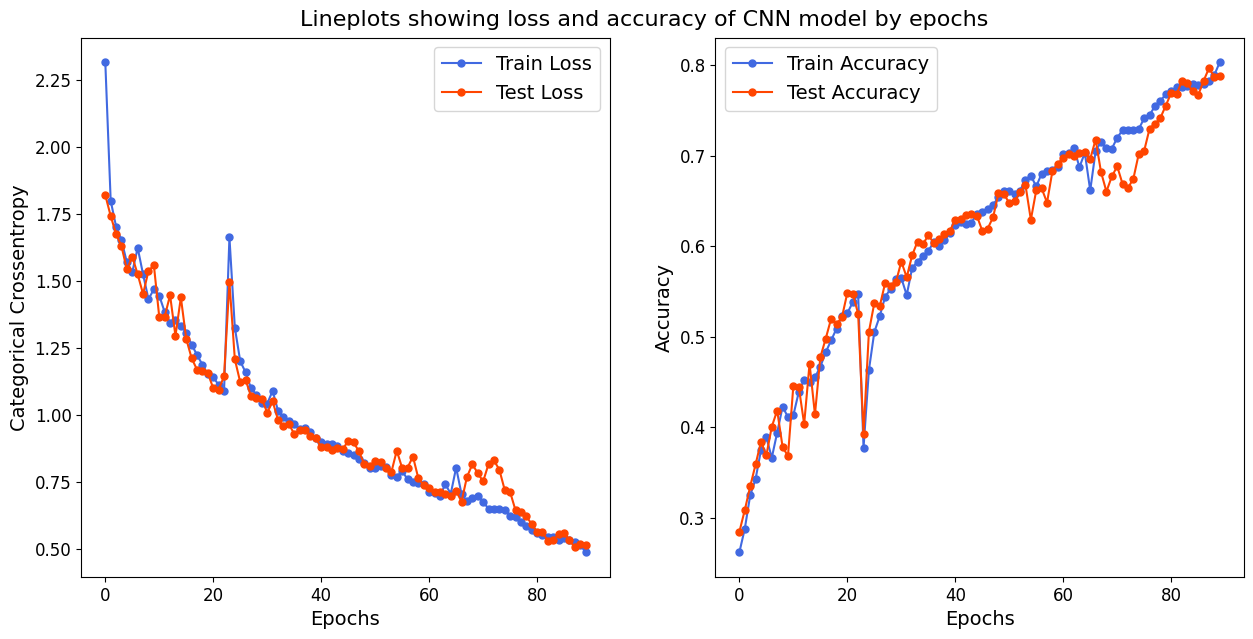

In [ ]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/combined_faces');

66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.7875 - loss: 0.5170


CNN model loss 		= 0.515
CNN model compile_metrics 	= 0.788
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step
Normalized confusion matrix


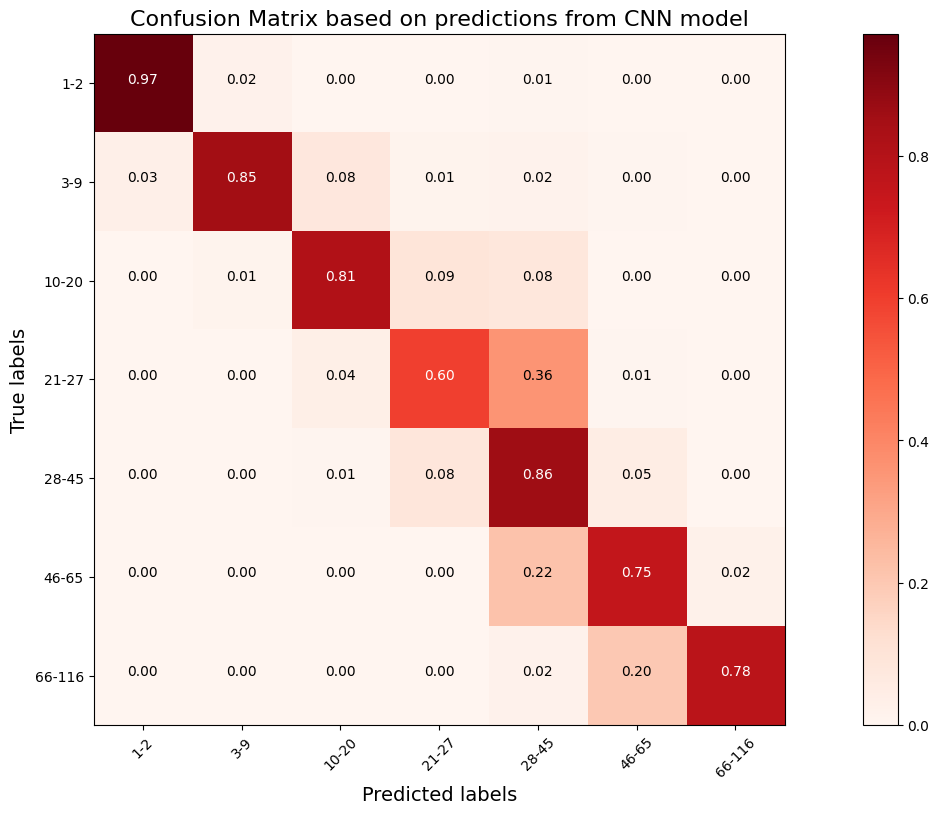

In [ ]:
# Evaluating the model on test dataset.
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

# Saving the model as a h5 file for possible use later.
final_cnn.save(f"/content/drive/My Drive/combined_faces/output/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

# Generating predictions from the model above.
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)

# Extract true labels from the test dataset
test_labels = np.concatenate([batch[1].numpy().argmax(axis=-1) for batch in test_dataset]) # Extract true labels

# Generating a confusion matrix based on above predictions and true labels.
conf_mat = confusion_matrix(test_labels, final_cnn_pred) # Use true labels instead of test accuracy

# Defining a function to plot the confusion matrix in a grid for easier visualization.
# ... (rest of the code)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Use cmap to set color
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/combined_faces/{export_as}.png');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-65', '66-116']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      cmap=plt.cm.Reds, # Pass the desired colormap to the cmap argument
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()

# ... (rest of the code)